# Exploring Titanic Data

Let's start with exploring the data

In [1]:
import csv as csv 
import numpy as np

#Open up the csv file in to a Python object
csv_file_object = csv.reader(open('./train.csv', 'rb'))
header = csv_file_object.next()  #The next() command just skips the first line which is a header
data=[] 

for row in csv_file_object:
    data.append(row)
data = np.array(data)   #convert a list to an array
print data

[['1' '0' '3' ..., '7.25' '' 'S']
 ['2' '1' '1' ..., '71.2833' 'C85' 'C']
 ['3' '1' '3' ..., '7.925' '' 'S']
 ..., 
 ['889' '0' '3' ..., '23.45' '' 'S']
 ['890' '1' '1' ..., '30' 'C148' 'C']
 ['891' '0' '3' ..., '7.75' '' 'Q']]


In [2]:
number_passengers = np.size(data[0::,1].astype(np.float))
number_survived = np.sum(data[0::,1].astype(np.float))
proportion_survivors = number_survived / number_passengers
print proportion_survivors

0.383838383838


In [3]:
women_only_stats = data[0::,4] == "female" # This finds where all the elements in the gender column that equals “female”
men_only_stats = data[0::,4] != "female"   # This finds where all the elements do not equal female (i.e. male)

# Using the index from above select the females and males separately
women_onboard = data[women_only_stats,1].astype(np.float)     
men_onboard = data[men_only_stats,1].astype(np.float)

# Then find the proportions of them that survived
proportion_women_survived = np.sum(women_onboard) / np.size(women_onboard)  
proportion_men_survived = np.sum(men_onboard) / np.size(men_onboard) 

# and then print it out
print 'Proportion of women who survived is %s' % proportion_women_survived
print 'Proportion of men who survived is %s' % proportion_men_survived

Proportion of women who survived is 0.742038216561
Proportion of men who survived is 0.188908145581


Now that I have my indication that women were much more likely to survive, I am done with the training set.

In [4]:
test_file = open('./test.csv', 'rb')       
test_file_object = csv.reader(test_file)
header = test_file_object.next()

In [5]:
#let's open a pointer to a new file so we can write to it (this file does not exist yet)
prediction_file = open("genderbasedmodel.csv", "wb")
prediction_file_object = csv.writer(prediction_file)

In [6]:
#now i am predicting that all female survived and no male survived 
prediction_file_object.writerow(["PassengerId", "Survived"])
for row in test_file_object:       # For each row in test.csv
    if row[3] == 'female':                                       
        prediction_file_object.writerow([row[0],'1'])    # predict 1
    else:       
        prediction_file_object.writerow([row[0],'0'])    # predict 0
test_file.close()
prediction_file.close()

genderbasemodel.csv is my first test case prediction file with accuracy of 0.76555

Next the idea is to create an table which contains just 1's and 0's. The array will be a survival reference table, whereby you read in the test data, find out passenger attributes, look them up in the survival table, and determine if they should be predicted to survive or not. In the case of a model that uses gender, class, and ticket price, you will need an array of 2x3x4 ( [female/male] , [1st / 2nd / 3rd class], [4 bins of prices] ).

The script will systematically will loop through each combination and use the 'where' function in python to search the passengers that fit that combination of variables. Just like before, you can ask what indices in your data equals female, 1st class, and paid more than 30 .The problem is that looping through requires bins of equal sizes, i.e. 0-9,  10-19, 20-29, 30-39.  For the sake of binning let's say everything equal to and above 40 "equals" 39 so it falls in this bin. So then you can set the bins:

In [9]:
# So we add a ceiling
fare_ceiling = 40
# then modify the data in the Fare column to = 39, if it is greater or equal to the ceiling
data[ data[0::,9].astype(np.float) >= fare_ceiling, 9 ] = fare_ceiling - 1.0

fare_bracket_size = 10
number_of_price_brackets = fare_ceiling / fare_bracket_size

# I know there were 1st, 2nd and 3rd classes on board
number_of_classes = 3

# But it's better practice to calculate this from the data directly
# Take the length of an array of unique values in column index 2
number_of_classes = len(np.unique(data[0::,2])) 

# Initialize the survival table with all zeros
survival_table = np.zeros((2, number_of_classes, number_of_price_brackets))


[[[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]]


In [50]:
for i in xrange(number_of_classes):       #loop through each class
    for j in xrange(number_of_price_brackets):   #loop through each price bin
        #ith class was greater than this bin and less than the next bin in the 2nd col  
        women_only_stats = data[ (data[0::,4] == "female") \
                            &(data[0::,2].astype(np.float)  == i+1) \
                            &(data[0:,9].astype(np.float) >= j*fare_bracket_size) \
                            &(data[0:,9].astype(np.float) < (j+1)*fare_bracket_size) , 1]

        men_only_stats = data[ (data[0::,4] != "female") \
                          &(data[0::,2].astype(np.float) == i+1) \
                          &(data[0:,9].astype(np.float) >= j*fare_bracket_size) \
                          &(data[0:,9].astype(np.float) < (j+1)*fare_bracket_size) , 1]    
        
        survival_table[0,i,j] = np.mean(women_only_stats.astype(np.float)) 
        survival_table[1,i,j] = np.mean(men_only_stats.astype(np.float))
        
survival_table[ survival_table != survival_table ] = 0.
print survival_table

[[[ 0.          0.          0.83333333  0.97727273]
  [ 0.          0.91428571  0.9         1.        ]
  [ 0.59375     0.58139535  0.33333333  0.125     ]]

 [[ 0.          0.          0.4         0.38372093]
  [ 0.          0.15873016  0.16        0.21428571]
  [ 0.11153846  0.23684211  0.125       0.24      ]]]


Notice that  data[ where function, 1]  means it is finding the Survived column for the conditional criteria which is being called. As the loop starts with i=0 and j=0, the first loop will return the Survived values for all the 1st-class females (i + 1) who paid less than 10 ((j+1)*fare_bracket_size) and similarly all the 1st-class males who paid less than 10.  Before resetting to the top of the loop, we can calculate the proportion of survivors for this particular combination of criteria and record it to our survival table:

Each of the number in the survival_table is the proportion of survivors for that criteria of passengers. For example, 0.91428571 signifies 91.4% of female, Pclass = 2, in the Fare bin of 10-19.

For our second model, let's again assume any probability greater than or equal to 0.5 should result in our predicting survival -- and less than 0.5 should not. We can update our survival table with:

In [51]:
survival_table[ survival_table < 0.5 ] = 0
survival_table[ survival_table >= 0.5 ] = 1 

print survival_table

[[[ 0.  0.  1.  1.]
  [ 0.  1.  1.  1.]
  [ 1.  1.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]]


When we go through each row of the test file we can find what criteria fit each new passenger and assign them a 1 or 0 according to our survival table.  As previously, let's open up the test file to read (and skip the header row), and also a new file to write to, called 'genderclassmodel.csv':

In [53]:
test_file = open('./test.csv', 'rb')
test_file_object = csv.reader(test_file)
header = test_file_object.next()
predictions_file = open("genderclassmodel.csv", "wb")
predictions_file_object = csv.writer(predictions_file)
predictions_file_object.writerow(["PassengerId", "Survived"])

As with the previous model, we can take the first passenger, look at his/her gender, class, and price of ticket, and assign a Survived label. The problem is that each passenger in the test.csv file is not binned. We should loop through each bin and see if the price of their ticket falls in that bin. If so, we can break the loop (so we don’t go through all the bins) and assign that bin:

In [55]:
# First thing to do is bin up the price file
for row in test_file_object:
    for j in xrange(number_of_price_brackets):
        # If there is no fare then place the price of the ticket according to class
        try:
            row[8] = float(row[8])    # No fare recorded will come up as a string so
                                      # try to make it a float
        except:                       # If fails then just bin the fare according to the class
            bin_fare = 3 - float(row[1])
            break                    # Break from the loop and move to the next row
        if row[8] > fare_ceiling:     # Otherwise now test to see if it is higher
                                      # than the fare ceiling we set earlier
            bin_fare = number_of_price_brackets - 1
            break                     # And then break to the next row

        if row[8] >= j*fare_bracket_size and row[8] < (j+1)*fare_bracket_size: # If passed these tests then loop through
                                                      # each bin until you find the right one
                                                      # append it to the bin_fare
                                                      # and move to the next loop
            bin_fare = j
            break
        # Now I have the binned fare, passenger class, and whether female or male, we can
        # just cross ref their details with our survival table
    if row[3] == 'female':
        predictions_file_object.writerow([row[0], "%d" % int(survival_table[ 0, float(row[1]) - 1, bin_fare ])])
    else:
        predictions_file_object.writerow([row[0], "%d" % int(survival_table[ 1, float(row[1]) - 1, bin_fare])])

# Close out the files
test_file.close()
predictions_file.close()

ValueError: I/O operation on closed file

this genderclassmodel.csv gave accuracy of 0.77990 which is better than the last accuracy by 0.01435 and surely some of the men survived, but our model can only predict 0.

# Now let's explore the data using Pandas and clean it for Machine Learning

In [213]:
import pandas as pd
import numpy as np

# For .read_csv, always use header=0 when you know row 0 is the header row
df = pd.read_csv('train.csv', header=0)

In [214]:
 df[df['Age'] > 60]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
33,34,0,2,"Wheadon, Mr. Edward H",male,66.0,0,0,C.A. 24579,10.5000,NaN,S
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q
170,171,0,1,"Van der hoef, Mr. Wyckoff",male,61.0,0,0,111240,33.5000,B19,S
252,253,0,1,"Stead, Mr. William Thomas",male,62.0,0,0,113514,26.5500,C87,S
275,276,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0,1,0,13502,77.9583,D7,S
280,281,0,3,"Duane, Mr. Frank",male,65.0,0,0,336439,7.7500,NaN,Q
326,327,0,3,"Nysveen, Mr. Johan Hansen",male,61.0,0,0,345364,6.2375,NaN,S
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,C23 C25 C27,S


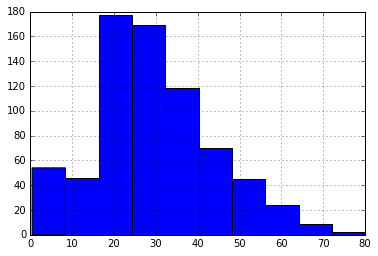

In [215]:
#for printing histogram in jupyter notebook
%matplotlib inline
import pylab as P
df['Age'].hist()
P.show()

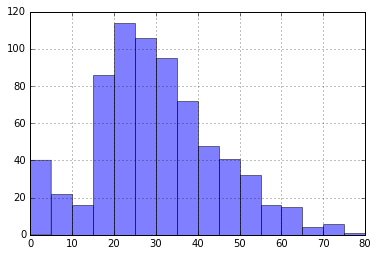

In [216]:
#dropping the missing value of age
df['Age'].dropna().hist(bins=16, range=(0,80), alpha = .5)
P.show()

In [217]:
#it's hard to run analysis on the string values of "male" and "female" so transforming it
df['Gender'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
df['Embarked-bool'] = df['Embarked'].map( {'C': 0, 'S': 1, 'Q':2} ).dropna().astype(int)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Embarked-bool
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1.0


Now it's time to deal with the missing values of Age, because most machine learning will need a complete set of values in that column to use it. By filling it in with guesses, we'll be introducing some noise into a model, but if we can keep our guesses reasonable, some of them should be close to the historical truth (whatever it was...), and the overall predictive power of Age might still make a better model than before.  We know the average [known] age of all passengers is 29.6991176 -- we could fill in the null values with that. But maybe the median would be better? (to reduce the influence of a few rare 70- and 80-year olds?) The Age histogram did seem positively skewed. 

For now let's decide to be more sophisticated, that we want to use the age that was typical in each passenger class. And decide that the median might be better. Let's build another reference table to calculate what each of these medians are:

In [218]:
median_ages = np.zeros((2,3))
median_ages

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [219]:
for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = df[(df['Gender'] == i) & (df['Pclass'] == j+1)]['Age'].dropna().median()
    
median_ages

array([[ 35. ,  28. ,  21.5],
       [ 40. ,  30. ,  25. ]])

We could fill in the missing ages directly into the Age column. But to be extra cautious and not lose the state of the original data, a more formal way would be to create a new column, AgeFill, and even record which ones were originally null (and thus artificially guessed).

Make a copy of Age:


In [220]:
df['AgeFill'] = df['Age']

df[ df['Age'].isnull() ][['Gender','Pclass','Age','AgeFill']].head(10) #top 10 rows with missing age value

,Gender,Pclass,Age,AgeFill
5,1,3,NaN,NaN
17,1,2,NaN,NaN
19,0,3,NaN,NaN
26,1,3,NaN,NaN
28,0,3,NaN,NaN
29,1,3,NaN,NaN
31,0,1,NaN,NaN
32,0,3,NaN,NaN
36,1,3,NaN,NaN
42,1,3,NaN,NaN


In [221]:
for i in range(0, 2):
    for j in range(0, 3):
        df.loc[ (df.Age.isnull()) & (df.Gender == i) & (df.Pclass == j+1), 'AgeFill'] = median_ages[i,j]

df[ df['Age'].isnull() ][['Gender','Pclass','Age','AgeFill']].head(10)

,Gender,Pclass,Age,AgeFill
5,1,3,NaN,25.0
17,1,2,NaN,30.0
19,0,3,NaN,21.5
26,1,3,NaN,25.0
28,0,3,NaN,21.5
29,1,3,NaN,25.0
31,0,1,NaN,35.0
32,0,3,NaN,21.5
36,1,3,NaN,25.0
42,1,3,NaN,25.0


In [222]:
df['AgeIsNull'] = pd.isnull(df.Age).astype(int) #to record whether the Age was originally missing
df[ df['Age'].isnull() ][['Gender','Pclass','Age','AgeFill','AgeIsNull']].head(10)

,Gender,Pclass,Age,AgeFill,AgeIsNull
5,1,3,NaN,25.0,1
17,1,2,NaN,30.0,1
19,0,3,NaN,21.5,1
26,1,3,NaN,25.0,1
28,0,3,NaN,21.5,1
29,1,3,NaN,25.0,1
31,0,1,NaN,35.0,1
32,0,3,NaN,21.5,1
36,1,3,NaN,25.0,1
42,1,3,NaN,25.0,1


In [223]:
#creating a couple of other features
df['FamilySize'] = df['SibSp'] + df['Parch']
df['Age*Class'] = df.AgeFill * df.Pclass

We have our data almost ready for machine learning. But most basic ML techniques will not work on strings, and in python they almost always require the data to be an array-- the implementations we will see in the sklearn package are not written to use a pandas dataframe. So the last two things we need to do are (1) determine what columns we have left which are not numeric, and (2) send our pandas.DataFrame back to a numpy.array.

In [224]:
df.dtypes[df.dtypes.map(lambda x: x=='object')]

Name        object
Sex         object
Ticket      object
Cabin       object
Embarked    object
dtype: object

In [225]:
#The next step is to drop the columns which we will not use
df = df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1) 

#We can also drop 'Age' even though it is numeric, since we copied and filled that to a better column AgeFill. 
df = df.drop(['Age'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId      891 non-null int64
Survived         891 non-null int64
Pclass           891 non-null int64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Gender           891 non-null int64
Embarked-bool    889 non-null float64
AgeFill          891 non-null float64
AgeIsNull        891 non-null int64
FamilySize       891 non-null int64
Age*Class        891 non-null float64
dtypes: float64(4), int64(8)
memory usage: 83.6 KB


In [226]:
#drop any rows which still have missing values
# remember that .dropna() removes an observation from df even if it only has 1 NaN, anywhere, in any of its columns.
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
PassengerId      889 non-null int64
Survived         889 non-null int64
Pclass           889 non-null int64
SibSp            889 non-null int64
Parch            889 non-null int64
Fare             889 non-null float64
Gender           889 non-null int64
Embarked-bool    889 non-null float64
AgeFill          889 non-null float64
AgeIsNull        889 non-null int64
FamilySize       889 non-null int64
Age*Class        889 non-null float64
dtypes: float64(4), int64(8)
memory usage: 90.3 KB


In [227]:
#The final step is to convert it into a Numpy array
train_data = df.values
train_data

array([[   1. ,    0. ,    3. , ...,    0. ,    1. ,   66. ],
       [   2. ,    1. ,    1. , ...,    0. ,    1. ,   38. ],
       [   3. ,    1. ,    3. , ...,    0. ,    0. ,   78. ],
       ..., 
       [ 889. ,    0. ,    3. , ...,    1. ,    3. ,   64.5],
       [ 890. ,    1. ,    1. , ...,    0. ,    0. ,   26. ],
       [ 891. ,    0. ,    3. , ...,    0. ,    0. ,   96. ]])

# Now let's start with Machine Learning using Random Forests algorithm

In [228]:
#dropping the PassengerId column
train_data =  np.delete(train_data, 0, 1)
train_data

array([[  0. ,   3. ,   1. , ...,   0. ,   1. ,  66. ],
       [  1. ,   1. ,   1. , ...,   0. ,   1. ,  38. ],
       [  1. ,   3. ,   0. , ...,   0. ,   0. ,  78. ],
       ..., 
       [  0. ,   3. ,   1. , ...,   1. ,   3. ,  64.5],
       [  1. ,   1. ,   0. , ...,   0. ,   0. ,  26. ],
       [  0. ,   3. ,   0. , ...,   0. ,   0. ,  96. ]])

In [229]:
test_df = pd.read_csv('test.csv', header=0)
test_df['Gender'] = test_df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
test_df['Embarked-bool'] = test_df['Embarked'].map( {'C': 0, 'S': 1, 'Q':2} ).dropna().astype(int)
test_df['AgeFill'] = test_df['Age']
for i in range(0, 2):
    for j in range(0, 3):
        test_df.loc[ (test_df.Age.isnull()) & (test_df.Gender == i) & (test_df.Pclass == j+1), 'AgeFill'] = median_ages[i,j]
test_df['AgeIsNull'] = pd.isnull(test_df.Age).astype(int)
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch']
test_df['Age*Class'] = test_df.AgeFill * test_df.Pclass
test_df.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Embarked-bool,AgeFill,AgeIsNull,FamilySize,Age*Class
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,1,2,34.5,0,0,103.5
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,1,47.0,0,1,141.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1,2,62.0,0,0,124.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,1,1,27.0,0,0,81.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,1,22.0,0,2,66.0
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,1,1,14.0,0,0,42.0
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,0,2,30.0,0,0,90.0
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,1,1,26.0,0,2,52.0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,0,0,18.0,0,0,54.0
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,1,1,21.0,0,2,63.0


In [230]:
test_df.dtypes[test_df.dtypes.map(lambda x: x=='object')]

Name        object
Sex         object
Ticket      object
Cabin       object
Embarked    object
dtype: object

In [231]:
#The next step is to drop the columns which we will not use
test_df = test_df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1) 

#We can also drop 'Age' even though it is numeric, since we copied and filled that to a better column AgeFill. 
test_df = test_df.drop(['Age'], axis=1)

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId      418 non-null int64
Pclass           418 non-null int64
SibSp            418 non-null int64
Parch            418 non-null int64
Fare             417 non-null float64
Gender           418 non-null int64
Embarked-bool    418 non-null int64
AgeFill          418 non-null float64
AgeIsNull        418 non-null int64
FamilySize       418 non-null int64
Age*Class        418 non-null float64
dtypes: float64(3), int64(8)
memory usage: 36.0 KB


In [232]:
#test_df = test_df.dropna()
test_df.fillna(0, inplace=True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId      418 non-null int64
Pclass           418 non-null int64
SibSp            418 non-null int64
Parch            418 non-null int64
Fare             418 non-null float64
Gender           418 non-null int64
Embarked-bool    418 non-null int64
AgeFill          418 non-null float64
AgeIsNull        418 non-null int64
FamilySize       418 non-null int64
Age*Class        418 non-null float64
dtypes: float64(3), int64(8)
memory usage: 36.0 KB


In [233]:
test_data = test_df.values
test_data =  np.delete(test_data, 0, 1)
test_data

array([[   3. ,    0. ,    0. , ...,    0. ,    0. ,  103.5],
       [   3. ,    1. ,    0. , ...,    0. ,    1. ,  141. ],
       [   2. ,    0. ,    0. , ...,    0. ,    0. ,  124. ],
       ..., 
       [   3. ,    0. ,    0. , ...,    0. ,    0. ,  115.5],
       [   3. ,    0. ,    0. , ...,    1. ,    0. ,   75. ],
       [   3. ,    1. ,    1. , ...,    1. ,    2. ,   75. ]])

In [234]:
# Import the random forest package
from sklearn.ensemble import RandomForestClassifier 

# Create the random forest object which will include all the parameters
# for the fit
forest = RandomForestClassifier(n_estimators = 100,min_samples_leaf = 10)

# Fit the training data to the Survived labels and create the decision trees
forest = forest.fit(train_data[0::,1::],train_data[0::,0])

# Take the same decision trees and run it on the test data
output = forest.predict(test_data)

In [235]:
prediction_file = open("randomForest.csv", "wb")
prediction_file_object = csv.writer(prediction_file)

In [236]:
test_file = open('./test.csv', 'rb')
test_file_object = csv.reader(test_file)
header = test_file_object.next()
i=0
prediction_file_object.writerow(["PassengerId", "Survived"])
for row in test_file_object:       # For each row in test.csv 
    if(i<418):
        prediction_file_object.writerow([row[0],output[i]])
        i=i+1
    else:
        break

test_file.close()
prediction_file.close()